# 第6回課題：CNNで文字認識をしよう

最も基本的な画像認識タスクとして、手書き文字（数字）認識をやってみましょう。   
深層学習による画像認識のためのアーキテクチャであるCNNの実装を使います。   
演習で配ったCIFAR-10のコードを参考にしてください。

<H2><font color="red">課題を提出する際は、画像が表示されている状態で保存し、このmp_ex6.ipynbファイルのみを提出してください。</font></H2>

## 今回挑戦する画像認識タスク
小規模な画像認識タスクとして、手書き文字のデータセット[MNIST(Mixed National Institute of Standards and Technology database)](http://yann.lecun.com/exdb/mnist/)を使って、０から９までの10種類の記号に対する文字認識を行います。   
MNISTは1枚あたり28x28ピクセルで、訓練データとして60,000枚、評価データとして10,000枚の画像が与えられています。    

## 利用するライブラリ
本プログラムでは、ニューラルネットワーク実装のためのライブラリとして、Kerasを利用しています。   

+ Keras Documentation: https://keras.io/ja/

## 実行環境：Colaboratoryを強く推奨します

CPUでも実行できると思いますが、モデルの学習に計算負荷がかかります。   
Colaboratoryで「ランタイム＞ランタイムのタイプを変更」で「ハードウェアアクセラレータ」をGPUにしてから実行することをお勧めします。

# 1. ライブラリのインストール

本プログラムでは、ニューラルネットワーク実装のためのライブラリとして、Kerasを利用しています。   
'keras'と、そのバックエンドである'tensorflow'をインストールします。   

**tensorflowのインストールによる不具合が見られるようです。**
**Colaboratoryの使用を強くお勧めします。**

## 1.1 ローカルPCの場合（非推奨）

**必ず仮想環境を作ってからパッケージをインストールしてください。**   
ガイダンスの環境設定の資料を参照して、ライブラリのインストールをお願いします。
1. Anaconda Navigatorを開く
2. 「Environments」のタブを開き、中央のフレームで「base(root)」とある右側の「▶」をクリックし、"Open Terminal"をクリック
3. コマンドプロンプトから以下の二つのコマンドを実行  

``conda install -c anaconda tensorflow``   
``conda install -c anaconda keras``

**トラブルが起きる場合はColaboratoryをご利用ください。**

## 1.2 Colaboratoryの場合（推奨）
以下のセルを実行してください。   
**このセルはColaboratoryを起動するたびに必要となります**   

In [1]:
##################################
### Colaboratoryのみ以下を実行 ###
##################################
import sys
if 'google.colab' in sys.modules:
    !pip install tensorflow
    !pip install keras

## ライブラリを読み込み

Kerasから今回使うライブラリをインポートしましょう。

In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np

# 計算するたびに違う答えにならないよう、ランダムシードを設定する
np.random.seed(seed=0)

Using TensorFlow backend.


# 2. 学習データの準備

## MNISTデータセットをダウンロード
MNIST datasetsは様々な場面で使われているので、Kerasのライブラリの中に、データセットをダウンロードするための関数が用意されています。   
これを使ってデータセットをダウンロードし、読み込みましょう。   
データサイズは11MBです。    
PCで以下のセルを実行すると、ダウンロードされたファイルがホームディレクトリの下の'.keras/datasets'の下に保存されています。   
次回から同じPC＋アカウントでこのコマンドを実行する際は、改めてダウンロードされることはありません。   
（Colaboratoryはランタイムを終了するとファイルがすべて消去されるため、毎回ダウンロードすることになります）

In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

入力画像を確認してみましょう。

x_trainは画像の集合で、 (60,000枚) x (28 pixel) x (28 pixel)のテンソルです。
1枚目の画像サイズを見ると、28x28であることがわかります。
MNISTはカラー画像ではなくグレースケール画像なので、チャネルは1です（カラーの場合はRGBの3チャネルでしたね）。

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


また、y_trainには60,000枚の各画像の正解のラベルが入っています。   

In [7]:
print(len(y_train)) # 60,000枚の画像のラベルが入っている
print(y_train[:10]) # 最初の10枚のラベル（整数値で記録されている）

60000
[5 0 4 1 9 2 1 3 1 4]


訓練画像を1枚表示させてみましょう。非常に画素が粗い画像であることがわかります。

Class label:  3


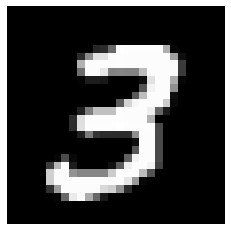

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 画像をいろいろと入れ替えてみましょう。
id =7
plt.imshow(x_train[id], cmap = "gray")
plt.axis('off')

print('Class label: ', y_train[id])

画像データの形を見てみましょう。

In [9]:
print(x_train.shape)

(60000, 28, 28)


CIFAR-10はカラー画像だったので、入力した時点でテンソルでしたが、グレースケール画像はチャネルが１なので、テンソルに変換する必要があります。

In [11]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

次元が1つ増えました。

In [12]:
print(x_train.shape)

(60000, 28, 28, 1)


## 正解ラベルをone-hotベクトルに変換
`y_train`や`y_test`は、そのアドレスに対応する画像の正解ラベルが0から9までの整数値で記録されています。   
一方、1枚の入力画像に対してCNNが最終層で出力するのは、その画像が0から9までの各クラスである尤もらしさ（確率）ですから、それに対応するように、正解ラベルもone-hotベクトル（すなわち、正解のクラスだけが1、残りが0のベクトル）に変換しましょう。   

クラスは全部で10クラスですから、10次元のone-hotベクトルに変換します。   
たとえば正解が「６」であるような画像のクラスは"6"ですが、これを10次元のone-hotベクトルに変換すると、(0から数えて)6番目だけが1で残りは0であるような`[0 0 0 0 0 0 1 0 0 0]`というベクトルに変換されます。   
これを、すべての画像（計60,000枚）について行うので、`y_train`は60,000x10の行列になります。

In [13]:
# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_trainのサイズと、最初の10枚分の中身を見てみましょう。

In [14]:
print('y_train shape:', y_train.shape)
print(y_train[:10])

y_train shape: (60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 画像の濃淡値を正規化

各画素の濃淡値は0～255までの整数値で記録されているので、255で割って0～1までの値に正規化します。

In [15]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 3. ネットワークを設計

以下のようなネットワークになるよう、モデルを設計してください。   
コードは'ImageRecognition3.ipynb'を参考にしてください。   
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
=================================================================
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
```


In [19]:
### 課題：教材を参考に、ネットワークのコードを書いてください
### この行を消さないでください!!! ---mp_ex6_task1--

model = Sequential()
# Convolution 1 フィルタ32枚、各フィルタのカーネルサイズ3x3 ストライドはデフォルト (1, 1)
model.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=x_train.shape[1:]))

# 'relu'で活性化
model.add(Activation('relu'))
# Convolution 2 フィルタ64枚、各フィルタのカーネルサイズ3x3 ストライドはデフォルト (1, 1)
model.add(Conv2D(64, (3, 3)))
# 'relu'で活性化
model.add(Activation('relu'))

# Max Pooling 1 (size: 2x2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# 25%のユニットをドロップアウト
model.add(Dropout(0.25))

# テンソルを一列のベクトルに平坦化
model.add(Flatten())
# Full Connection 1 # ユニット数128
model.add(Dense(128))
# 'relu'で活性化
model.add(Activation('relu'))
# 50%のユニットをドロップアウト
model.add(Dropout(0.5))
# Full Connection 2 # ユニット数はクラス数と同じ10
model.add(Dense(num_classes))
# 最後の活性化関数は出力を確率にするためsoftmaxを使用
model.add(Activation('softmax'))

ネットワーク構造のサマリを出力してみましょう。   
上で示した構造と一致しているか確認してください。

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)             

# 4. 学習
## 学習パラメータ設定

以下のパラメータを設定してください。
*   バッチサイズは128
*   エポック数は12

In [21]:
### 課題：?を書き換えてください
### この行を消さないでください!!! ---mp_ex6_task2--

batch_size = 128 # バッチサイズ
epochs = 12 # エポック数

## 最適化手法・損失関数・評価関数の設定
最適化手法を選択します。   

- 最適化手法は'Adam'を使ってください
- 判別問題として解いてください
- 精度は'accuracy'(正解率）で評価してください

In [23]:
### 課題：?を書き換えてください
### この行を消さないでください!!! ---mp_ex6_task3--

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

## 学習

上で設計したネットワークに訓練データを与えてモデルを学習します。   
**時間がかかりますので覚悟してください（お手持ちのPCに不安がある方は、Google Colaboratoryをご利用ください）。**


In [24]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 14s 241us/step - loss: 0.2421 - accuracy: 0.9263 - val_loss: 0.0535 - val_accuracy: 0.9840
Epoch 2/12
60000/60000 [==============================] - 8s 138us/step - loss: 0.0881 - accuracy: 0.9736 - val_loss: 0.0374 - val_accuracy: 0.9887
Epoch 3/12
60000/60000 [==============================] - 8s 138us/step - loss: 0.0639 - accuracy: 0.9796 - val_loss: 0.0335 - val_accuracy: 0.9889
Epoch 4/12
60000/60000 [==============================] - 8s 138us/step - loss: 0.0528 - accuracy: 0.9836 - val_loss: 0.0351 - val_accuracy: 0.9891
Epoch 5/12
60000/60000 [==============================] - 8s 138us/step - loss: 0.0468 - accuracy: 0.9855 - val_loss: 0.0296 - val_accuracy: 0.9906
Epoch 6/12
60000/60000 [==============================] - 8s 138us/step - loss: 0.0397 - accuracy: 0.9872 - val_loss: 0.0337 - val_accuracy: 0.9894
Epoch 7/12
60000/60000 [==============================] - 8s 

## 4. モデルの保存と評価

モデルの学習には長い時間がかかりますので、せっかく学習したモデルは保存しておきましょう。   
Colaboratoryで実行している場合は、保存後にPCにダウンロードしておかないと、ランタイムを停止する際に削除されてしまうのでご注意ください。

In [25]:
save_dir = os.path.join(os.getcwd(), 'saved_models') # モデルの保存先
model_name = 'keras_mnist_trained_model' # モデルを保存する際のファイル名
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/keras_mnist_trained_model 


正解率を評価します。

In [26]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 134us/step
Test loss: 0.031698465306697746
Test accuracy: 0.9914000034332275


# 入力データに対するクラスラベルの予測


どの画像がどのように判定されたか見てみましょう。  


[0]
Truth:  0 	Predicted:  0


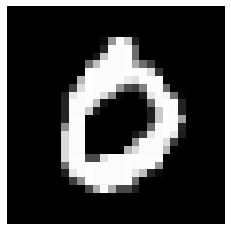

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# idをいろいろ入れ替えて、正解と予測を見比べてみましょう。
id = 3
plt.imshow(np.squeeze(x_test[id]), cmap='gray', vmin=0, vmax=1)
ans = np.argmax(y_test[id])
plt.axis('off')

target = x_test[id] # 単体の入力データを用意
predict_class = model.predict_classes( np.array([target]) )
print(predict_class)
print('Truth: ', ans, '\tPredicted: ', predict_class[0])

# 参考文献

MNIST: [Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)